In [2]:
from GeneralTools.misc_fun import FLAGS

FLAGS.TENSORFLOW_VERSION


'1.13.0'

In [3]:
"""
Dataset provided by:
Mohan S Acharya, Asfia Armaan, Aneeta S Antony. 
A Comparison of Regression Models for Prediction of Graduate Admissions, 
IEEE International Conference on Computational Intelligence in Data Science 2019.
"""
import numpy as np
import os.path

# csv file can also be read using pandas
data_file = np.genfromtxt(
    os.path.join(FLAGS.DEFAULT_IN, 'graduate_admission/Admission_Predict_Ver1.1.csv'), 
    delimiter=',', skip_header=1)  # the first row is header, which we skip
data_file.shape


(500, 9)

In [4]:
# The first row is header, the first column is index, the last column is label
x_np = data_file[:, 1:8]
y_np = data_file[:, 8]
print(x_np[0:4])
print(y_np[0:4])
print(y_np.shape)
y_np = np.expand_dims(y_np, axis=1)
print(y_np.shape)


[[337.   118.     4.     4.5    4.5    9.65   1.  ]
 [324.   107.     4.     4.     4.5    8.87   1.  ]
 [316.   104.     3.     3.     3.5    8.     1.  ]
 [322.   110.     3.     3.5    2.5    8.67   1.  ]]
[0.92 0.76 0.72 0.8 ]
(500,)
(500, 1)


In [6]:
# simple linear regression
import tensorflow as tf
import time

"""
tf.Graph() initializes a new graph.
some_graph.as_default() sets the some_graph as the graph to work on.
with some_graph defines a scope. All TensorFlow operations should be under the same graph/scope. 
"""
with tf.Graph().as_default(), tf.device('cpu:0'):
    # Workflow step 1. prepare data
    # tf.constant is one way to add the data to graph
    data = tf.constant(data_file[:, 1:], dtype=tf.float32)
    # shuffle the dataset
    data_shuffle = tf.random.shuffle(data, name='data_shuffle')
    # divide the dataset into training and test datasets
    data_tr = data_shuffle[0:400]  # 400-by-8, print(data_tr.get_shape().as_list()) -> [400, 8]
    data_te = data_shuffle[400:500]  # 100-by-8
    # scale the data
    mean_tr, var_tr = tf.nn.moments(data_tr, axes=[0], keep_dims=True)
    std_tr = tf.sqrt(var_tr + FLAGS.EPSI)  # print(mean_tr.get_shape().as_list()) -> [1, 8]
    data_tr = (data_tr - mean_tr) / std_tr
    data_te = (data_te - mean_tr) / std_tr
    # separate the features from targets
    x_tr = data_tr[:, :7]
    t_tr = tf.expand_dims(data_tr[:, 7], axis=1)
    x_te = data_te[:, :7]
    t_te = tf.expand_dims(data_te[:, 7], axis=1)
    
    # Workflow step 2. define the model
    """
    There are at least three ways to initialize trainable parameters:
    Using low level API:
        1. tf.Variable always initializes a new tensor when called;
        2. tf.get_variable initializes a new tensor when first called, can recall a previously 
        initialized tensor when called again (if variable scope is set properly);
    Using high level API
        3. tf.layer.* implicitly initializes trainable parameters using tf.get_variable.
    
    when trainable=True, the parameters are added to GraphKeys.TRAINABLE_VARIABLES and can be 
    returned using tf.trainable_variables() or tf.get_collection().
    """
    with tf.variable_scope('LinearModel0', reuse=tf.AUTO_REUSE):
        w0 = tf.get_variable(
            'weight', shape=(x_np.shape[1], y_np.shape[1]), dtype=tf.float32, 
            initializer=tf.random_normal_initializer, trainable=True)
        b0 = tf.get_variable(  # optional if we standardize the inputs and outputs in a linear model
            'bias', shape=[], dtype=tf.float32, 
            initializer=tf.random_normal_initializer, trainable=True)
        # print(tf.trainable_variables()) -> [<tf.Variable 'weight:0' shape=(7, 1) dtype=float32_ref>]
        y_tr = tf.matmul(x_tr, w0) + b0
        y_te = tf.matmul(x_te, w0) + b0
    with tf.name_scope('LinearModel1'):
        pass
    
    # Workflow step 3. define the loss function
    """
    tf.losses contains several standard loss functions like MSE, MAE, cross-entropy, hinge
    User-defined loss can be added.
    The loss function constructed will by default be added to tf.GraphKeys.LOSSES
    https://www.tensorflow.org/api_docs/python/tf/losses
    """
    loss = tf.losses.mean_squared_error(
        t_tr, y_tr, reduction=tf.losses.Reduction.SUM_OVER_BATCH_SIZE, scope='train_loss')
    loss_te = tf.losses.mean_squared_error(
        t_te, y_te, reduction=tf.losses.Reduction.SUM_OVER_BATCH_SIZE, scope='test_loss')
    
    # Workflow step 4. configure the optimizer
    # configure learning rate
    global_step = tf.get_variable(
        name='global_step', shape=[], dtype=tf.int32, 
        initializer=tf.constant_initializer(0), trainable=False)
    # decayed_learning_rate = learning_rate * decay_rate ^ (global_step / decay_steps)
    init_learning_rate = 1.0
    decay_steps = np.round(1000 * np.log(0.96) / np.log(0.001 / init_learning_rate)).astype(np.int32)
    print('The decay step is {}'.format(decay_steps))
    learning_rate = tf.train.exponential_decay(  # adaptive learning rate
            0.5,
            global_step=global_step,
            decay_steps=decay_steps,
            decay_rate=0.96,
            staircase=False, name='decay_lr')
    # configure optimizer
    # see other optimizers at: https://www.tensorflow.org/api_docs/python/tf/train
    # include: MomentumOptimizer, AdamOptimizer, RMSPropOptimizer
    opt = tf.train.GradientDescentOptimizer(
        learning_rate=init_learning_rate, name='GD')
    # configure optimization process
    # the following can also be done as 
    # opt_op = opt.minimize(loss, global_step=global_step)
    var_list = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope=None)
    grads_list = opt.compute_gradients(loss, var_list)
    opt_op = opt.apply_gradients(grads_list, global_step=global_step)
    
    # Workflow step 5. configure the summary
    # summary op is always pinned to CPU
    tf.summary.histogram('weights', w0)
    tf.summary.scalar('bias', b0)  # normally bias would be a vector, so histogram too
    tf.summary.scalar('loss/train', loss)
    tf.summary.scalar('loss/test', loss_te)
    for grads in grads_list:
        var_grad = grads[0]
        var = grads[1]
        var_name = var.name.replace(':', '_')
        tf.summary.histogram('grad_' + var_name, var_grad)
        tf.summary.histogram(var_name, var)
    summary_op = tf.summary.merge_all()
    summary_folder = os.path.join(FLAGS.DEFAULT_OUT, 'graduate_admission' + '_log')
    if not os.path.exists(summary_folder):
        os.makedirs(summary_folder)
    
    # Workflow step 6. call a session
    sess = tf.Session(config=tf.ConfigProto(
        allow_soft_placement=True,
        log_device_placement=False))
    # initialize the graph
    init_op = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())
    sess.run(init_op)
    # configure where to write the summary file
    summary_writer = tf.summary.FileWriter(summary_folder, sess.graph)
    # run the session
    start_time = time.time()
    max_iter = 1000
    for step in range(max_iter):
        loss_value, _, global_step_value = sess.run([loss, opt_op, global_step])
        # check if model produces nan outcome
        assert not np.isnan(loss_value), \
            'Model diverged with loss = {} at step {}'.format(loss_value, global_step_value)
        
        # add summary and print loss every query step
        if global_step_value % 50 == 1 or global_step_value == max_iter:
            loss_te_value = sess.run(loss_te)
            if summary_op is not None:
                summary_str = sess.run(summary_op)
                summary_writer.add_summary(summary_str, global_step=global_step_value)
            print('Step {}: training loss is {:.4f}; test loss is {:.4f}'.format(
                global_step_value, loss_value, loss_te_value))
            
    duration = time.time() - start_time
    print('Training for {} steps took {:.3f} sec.'.format(max_iter, duration))
    sess.close()


The decay step is 6


Step 1: training loss is 14.6889; test loss is 939.3680


AssertionError: Model diverged with loss = nan at step 43

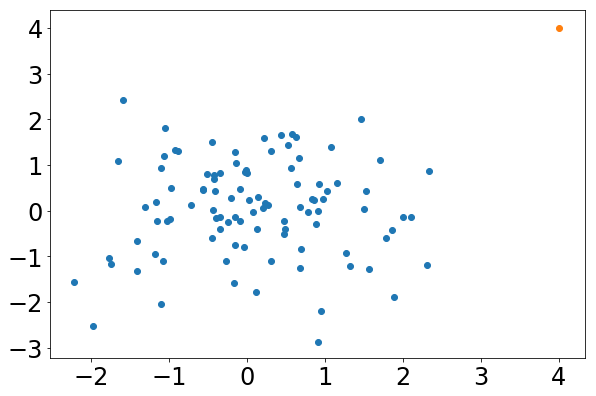